In [125]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style('whitegrid')

import matplotlib as mpl

from IPython.display import display

import matplotlib.pylab as pylab

from matplotlib import rc
import matplotlib

import torch
from torch.nn.functional import log_softmax
from sklearn.model_selection import KFold
from scipy.optimize import minimize
from matplotlib.lines import Line2D
%matplotlib inline

matplotlib.rcParams['text.usetex'] = True

# Read logs

In [126]:
import glob

In [127]:
path = 'final-logs/'
dfs = [pd.read_csv(path + f) for f in os.listdir(path) if f.endswith('.csv')]

for df in dfs:
    df['data'] = df.apply(lambda x: 'randaugment', axis=1)
    df['experiment'] = df.apply(lambda x: x.fname.split('_')[0], axis=1)
    df.method = df.apply(lambda x: (x.fname.split('_')[1] + ' ' + x.method.split('randaugment')[-1].strip()).strip(), axis=1)
    
df = pd.concat(dfs, sort=False)
df.value = df.apply(lambda x: x.value * 100 if x.metric in ['acc', 'acc (ts)'] else x.value, axis=1)
df = df.groupby(['dataset', 'model', 'method', 'n_samples', 'metric', 'experiment']).value.agg(['mean', 'std', 'max']).reset_index()

In [128]:
dataset = "CIFAR10"
model = "VGG16BN"
setup = "SETUP1"
metric = "ll"
method = "GPS (ts)"
n_samples = 10
# df.query(f'model=="{model}" and n_samples=="{n_samples}" and dataset=="{dataset}" and experiment=="{setup}" and metric=="{metric}" and method=="{method}"')
df.query(f'n_samples=="{n_samples}" and experiment=="{setup}" and metric=="{metric}" and method=="{method}"')

,dataset,model,method,n_samples,metric,experiment,mean,std,max
10116,CIFAR10,PreResNet110,GPS (ts),10,ll,SETUP1,-0.080251,0.001198,-0.079028
23136,CIFAR10,VGG16BN,GPS (ts),10,ll,SETUP1,-0.090776,0.001231,-0.089701
36156,CIFAR10,WideResNet28x10,GPS (ts),10,ll,SETUP1,-0.054176,0.000723,-0.053505
49724,CIFAR100,PreResNet110,GPS (ts),10,ll,SETUP1,-0.575664,0.001923,-0.572597
66744,CIFAR100,VGG16BN,GPS (ts),10,ll,SETUP1,-0.690425,0.002322,-0.688378
84774,CIFAR100,WideResNet28x10,GPS (ts),10,ll,SETUP1,-0.519029,0.002170,-0.516626


In [129]:
df

,dataset,model,method,n_samples,metric,experiment,mean,std,max
0,CIFAR10,PreResNet110,CF,1,acc,SETUP1,96.942000,0.075631,97.070000
1,CIFAR10,PreResNet110,CF,1,acc,SETUP3,95.084000,0.080187,95.140000
2,CIFAR10,PreResNet110,CF,1,acc_aac,SETUP1,0.003008,0.000063,0.003087
3,CIFAR10,PreResNet110,CF,1,acc_aac,SETUP3,0.005526,0.000140,0.005656
4,CIFAR10,PreResNet110,CF,1,brier,SETUP1,0.046620,0.000656,0.047305
...,...,...,...,...,...,...,...,...,...
95125,CIFAR100,WideResNet28x10,ll (ts),100,acc,SETUP2,86.216000,0.045056,86.280000
95126,CIFAR100,WideResNet28x10,ll (ts),100,acc_aac,SETUP2,0.027234,0.000121,0.027343
95127,CIFAR100,WideResNet28x10,ll (ts),100,brier,SETUP2,0.197649,0.000386,0.198034
95128,CIFAR100,WideResNet28x10,ll (ts),100,ll,SETUP2,-0.488741,0.001326,-0.486787


In [130]:
colors = {'VGG16BN': 'r',
          'PreResNet110': 'g',
          'WideResNet28x10': 'b'
         }
linestyles = {'CF': 'dashed',
              'MGrid': 'dotted',
              'MTrain': 'dotted',
              'GPS': 'solid',
              'Clean': (0, (1, 10))
             }
markers = {'CF': '+',
           'MGrid': (5, 0),
           'MTrain': (5, 0),
           'GPS': (5, 1),
           'Clean' : '>'
          }
legend_augs = {'CF': 'Standard crops and flips',
              'MGrid': 'Randaugment with M*',
              'MTrain': 'Augmentation as in training',
              'GPS': 'Optimal GPS policy',
              'Clean': 'Central crop'}
short_legend_augs = {'CF': 'CF',
                     'MGrid': 'M*',
                     'GPS': 'GPS',
                     'MTrain': 'Tr',
                     'Clean': 'CC'}
model_names = {'VGG16BN': 'VGG',
              'PreResNet110': 'ResNet110',
              'WideResNet28x10': 'WideResNet'}
metric_names = {'ll': r'Calibrated''\n'r'log-likelihood',
                'acc': 'Accuracy (\%)'}
colors_augs = {'CF': 0,
             'MGrid': 1,
             'GPS': 2,
             'Clean': 3,
             'MTrain': 4}
colors_palette = [
    '#bcbd22', '#e377c2', '#9467bd',
    '#8c564b', '#1f77b4', '#d62728',
    '#2ca02c', '#ff7f0e', '#7f7f7f']
dataset_names = {'CIFAR10': 'CIFAR-10',
                'CIFAR100': 'CIFAR-100'}

# SETUP1 - CIFAR IN-DOMAIN

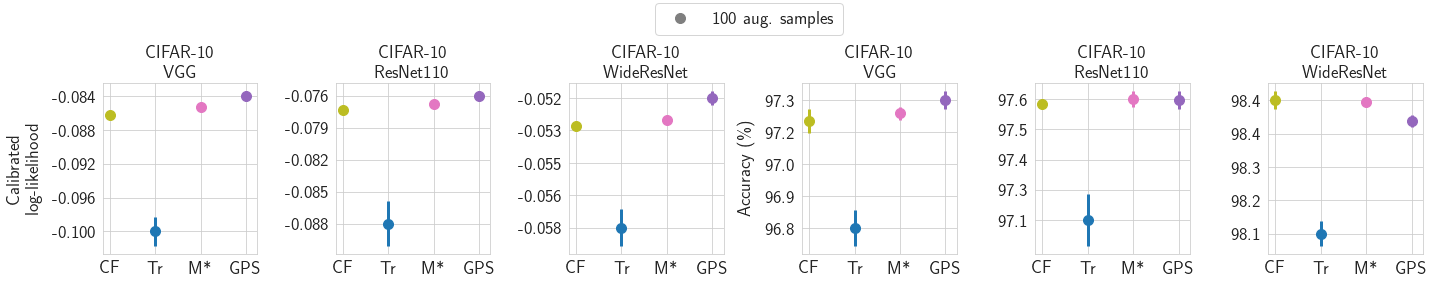

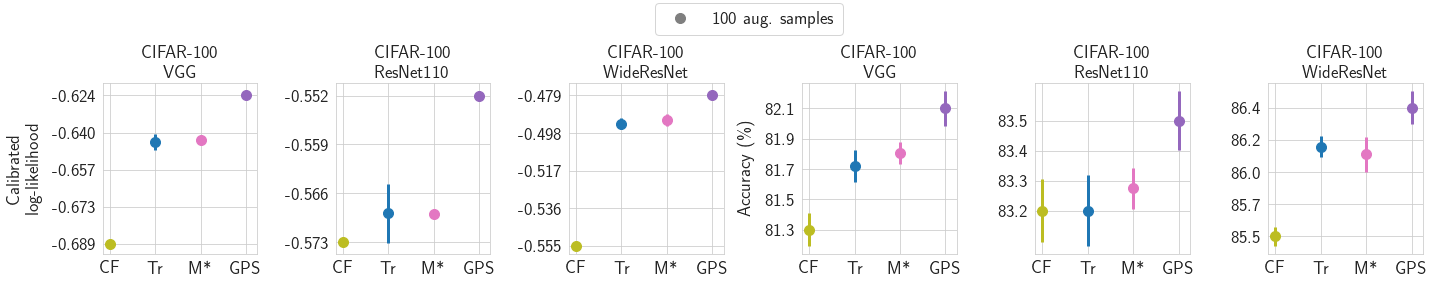

In [131]:
datasets = ['CIFAR10', 'CIFAR100']
# locator_bases = [0.01, 0.005, 0.005, 0.25, 0.25, 0.2,
#                  0.1, 0.05, 0.05, 1, 0.5, 1]
glob_i = -1
for dataset in datasets:
    params = {'legend.fontsize': 18,
             'axes.labelsize': 18,
    #          'figure.figsize': (6, 4),
             'axes.titlesize':18,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'lines.markersize': 10,
             'legend.markerscale': 1.,
             'legend.labelspacing': 1.,
             'figure.subplot.hspace': 0.3,
             'figure.subplot.wspace': 0.05,
             }
    pylab.rcParams.update(params)
    # models = ['VGG16BN', 'PreResNet110']
    models = [ 'VGG16BN', 'PreResNet110', 'WideResNet28x10']
#     augs = [ 'Clean', 'CF', 'MTrain', 'MGrid', 'GPS']
    augs = [ 'CF', 'MTrain', 'MGrid', 'GPS']
    sample_nums = [100]

    f = plt.figure(figsize=(20, 3.5))
    i = 1
    short_legend_augs_ordered = []
    for aug in augs:
        short_legend_augs_ordered.append(short_legend_augs[aug])
    metrics = ['ll', 'acc']
    for metric in metrics:
        for model in models:
            min_ = +150000
            max_ = -100500
            ax = plt.subplot(1, len(models) * len(metrics), i)
            glob_i += 1
            i += 1
            lines = []
            for j, aug in enumerate(augs):
                plot_augs = []
                legends = []
                for sample_num in sample_nums:
    #                 plot_augs.append(metric[dataset][model][aug][sample_num])
                    marker = 'o'
                    if sample_num == 5 and aug == "MTrain":
                        continue
                    if sample_num == 5:
                        marker = 'x'
                    if aug == 'Clean':
                        marker = (5, 1)
                    if aug != 'Clean' or sample_num == 100:
                        if aug == 'Clean':
                            sample_num = 1
                        val = df.query('dataset=="%s" and model=="%s" and method=="%s" and metric=="%s" and n_samples==%d and experiment=="SETUP1"' % (dataset, model, aug + ' (ts)', metric, sample_num))['mean'].item()
                        std = df.query('dataset=="%s" and model=="%s" and method=="%s" and metric=="%s" and n_samples==%d and experiment=="SETUP1"' % (dataset, model, aug + ' (ts)', metric, sample_num))['std'].item()
                        
                        min_ = min(min_, val)
                        max_ = max(max_, val)
                        
                        # GOVNOKOD, SORYAN
                        pos_x = j + 0.2 * ((sample_num < 100) - 0.5) * (len(sample_nums) == 2)
#                         pos_x = j
                        
                        plt.errorbar([pos_x], [val], [std], c=colors_palette[colors_augs[aug]], elinewidth=3)
                        legends.append(plt.scatter([pos_x], [val], marker=marker,
                                    c=colors_palette[colors_augs[aug]]))
        
                plt.title(dataset_names[dataset] + '\n' + model_names[model])
                plt.xticks(np.arange(len(augs)), short_legend_augs_ordered)
                plt.yticks(np.linspace(min_, max_, 4 if dataset == 'CIFAR100' and model == 'PreResNet110' else 5))
                if metric == 'll':
                    from matplotlib.ticker import FormatStrFormatter
                    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                else:
                    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#                 ax.yaxis.set_major_locator(plt.MultipleLocator(base=locator_bases[glob_i]))
#                 plt.axes().ticklabel_format(axis='y', style='plain')
                if i % (len(models)) == 2:
                    plt.ylabel(metric_names[metric], labelpad=10)
    # lines[0]['facecolor'] = colors_palette[-1]
    # for i in range(2):
    #     legends[i].set_color(colors_palette[-1])
    # f.legend(legends, labels=['20 samples', '100 samples'], ncol=2, loc='upper center',
    #         bbox_to_anchor=(0.5, 1.08))
    handles = []
    if len(sample_nums) == 2:
        star = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker=(5, 1), linestyle='None',
                          label='1 aug. sample')
        handles.append(star)
        cross = plt.plot(np.nan, np.nan, color=colors_palette[-1], marker='x', linestyle='None',
                                  label='%d aug. samples' % sample_nums[0])[0]
        handles.append(cross)
        circle = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker='o', linestyle='None',
                                  label='100 aug. samples')
        handles.append(circle)
        f.legend(handles=handles, loc='upper center', ncol=3,
                bbox_to_anchor=(0.5, 1.15))
    else:
#         star = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker=(5, 1), linestyle='None',
#                           label='1 aug. sample')
#         handles.append(star)
        circle = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker='o', linestyle='None',
                                  label='100 aug. samples')
        handles.append(circle)
        f.legend(handles=handles, loc='upper center', ncol=2,
                bbox_to_anchor=(0.52, 1.15))
    plt.tight_layout()
    plt.savefig('in-domain-%s.pdf' % dataset, bbox_inches="tight")

In [132]:
locator_bases = [0.01, 0.005, 0.005, 0.25, 0.25, 0.2,
                 0.1, 0.05, 0.05, 1, 0.5, 1]

# SETUP 2 - SELECTION WITH DIFFERENT METRICS

In [133]:
df.query('experiment=="SETUP2" and n_samples=="100" and metric == "ll"')

,dataset,model,method,n_samples,metric,experiment,mean,std,max
53578,CIFAR100,PreResNet110,acc,100,ll,SETUP2,-2.577278,0.002358,-2.574310
54078,CIFAR100,PreResNet110,acc (ts),100,ll,SETUP2,-0.691385,0.000849,-0.690247
54578,CIFAR100,PreResNet110,cll,100,ll,SETUP2,-0.675572,0.000707,-0.674588
55078,CIFAR100,PreResNet110,cll (ts),100,ll,SETUP2,-0.551945,0.001196,-0.550432
55578,CIFAR100,PreResNet110,ll,100,ll,SETUP2,-0.562676,0.000503,-0.562039
56078,CIFAR100,PreResNet110,ll (ts),100,ll,SETUP2,-0.559968,0.000621,-0.559205
70598,CIFAR100,VGG16BN,acc,100,ll,SETUP2,-2.645438,0.001073,-2.644040
71098,CIFAR100,VGG16BN,acc (ts),100,ll,SETUP2,-0.837226,0.002509,-0.833575
71598,CIFAR100,VGG16BN,cll,100,ll,SETUP2,-0.739380,0.001091,-0.738199
72098,CIFAR100,VGG16BN,cll (ts),100,ll,SETUP2,-0.622549,0.001211,-0.621133


In [134]:
linestyles = {'acc': 'dashed',
              'll': 'dotted',
              'cll': 'solid'
             }
markers = {'acc': '+',
           'll': (5, 0),
           'cll': (5, 1)
          }
legend_augs = {'acc': 'Accuracy (\%)',
              'll': 'Log-likelihood',
              'cll': 'Calibrated log-likelihood'}
short_legend_augs = {'acc': 'Acc',
                     'll': 'LL',
                     'cll': 'CLL'}
metric_names = {'ll': 'Calibrated log-likelihood',
                'acc': 'Accuracy (\%)'}
colors_augs = {'acc': 0,
             'll': 1,
             'cll': 2}

In [135]:
df.query('method=="cll (ts)" and metric=="ll" and n_samples==100 and experiment=="SETUP2"')

,dataset,model,method,n_samples,metric,experiment,mean,std,max
55078,CIFAR100,PreResNet110,cll (ts),100,ll,SETUP2,-0.551945,0.001196,-0.550432
72098,CIFAR100,VGG16BN,cll (ts),100,ll,SETUP2,-0.622549,0.001211,-0.621133
94128,CIFAR100,WideResNet28x10,cll (ts),100,ll,SETUP2,-0.478856,0.000769,-0.477946


In [136]:
res = []
for method in ['acc (ts)', 'll (ts)', 'cll (ts)']:
    for model in ['VGG16BN', 'PreResNet110', 'WideResNet28x10']:
        for metric in ['acc', 'll']:
            res.append(df.query('model=="%s" and method=="%s" and metric=="%s" and n_samples==100 and experiment=="SETUP2"' % (model, method, metric))['mean'].item())
            res.append(df.query('model=="%s" and method=="%s" and metric=="%s" and n_samples==100 and experiment=="SETUP2"' % (model, method, metric))['std'].item())

In [137]:
print(r"""\begin{table*}[]
\centering
\resizebox{\textwidth}{!}{\begin{tabular}{rcccccc}
\toprule
\multicolumn{1}{l}{}                                                & \multicolumn{2}{c}{VGG}                           & \multicolumn{2}{c}{ResNet110}                        & \multicolumn{2}{c}{WideResNet}                           \\
\cmidrule(lr){2-3}\cmidrule(lr){4-5}\cmidrule(lr){6-7}
\multicolumn{1}{r}{Criterion for GPS}                                                & \multicolumn{1}{c}{Acc} & \multicolumn{1}{c}{cLL} & \multicolumn{1}{c}{Acc} & \multicolumn{1}{c}{cLL} & \multicolumn{1}{c}{Acc} & \multicolumn{1}{c}{cLL} \\
\cmidrule(lr){1-1}\cmidrule(lr){2-2}\cmidrule(lr){3-3}\cmidrule(lr){4-4}\cmidrule(lr){5-5}\cmidrule(lr){6-6}\cmidrule(lr){7-7}
Accuracy (%s)                                                            & $%.2f\pm%.2f$ & $%.3f\pm%.3f$ & $%.2f\pm%.2f$ & $%.3f\pm%.3f$ & $%.2f\pm%.2f$ & $%.3f\pm%.3f$ \\
Log-likelihood                                                      & $%.2f\pm%.2f$ & $%.3f\pm%.3f$ & $\mathbf{%.2f\pm%.2f}$ & $%.3f\pm%.3f$ & $%.2f\pm%.2f$ & $%.3f\pm%.3f$ \\
\begin{tabular}[c]{@{}r@{}}Calibrated log-likelihood\end{tabular} & $\mathbf{%.2f\pm%.2f}$ & $\mathbf{%.3f\pm%.3f}$ & $\mathbf{%.2f\pm%.2f}$ & $\mathbf{%.3f\pm%.3f}$ & $\mathbf{%.2f\pm%.2f}$ & $\mathbf{%.3f\pm%.3f}$ \\
\bottomrule
\end{tabular}}
\end{table*}""" % (("\%",)+tuple(res)))

\begin{table*}[]
\centering
\resizebox{\textwidth}{!}{\begin{tabular}{rcccccc}
\toprule
\multicolumn{1}{l}{}                                                & \multicolumn{2}{c}{VGG}                           & \multicolumn{2}{c}{ResNet110}                        & \multicolumn{2}{c}{WideResNet}                           \\
\cmidrule(lr){2-3}\cmidrule(lr){4-5}\cmidrule(lr){6-7}
\multicolumn{1}{r}{Criterion for GPS}                                                & \multicolumn{1}{c}{Acc} & \multicolumn{1}{c}{cLL} & \multicolumn{1}{c}{Acc} & \multicolumn{1}{c}{cLL} & \multicolumn{1}{c}{Acc} & \multicolumn{1}{c}{cLL} \\
\cmidrule(lr){1-1}\cmidrule(lr){2-2}\cmidrule(lr){3-3}\cmidrule(lr){4-4}\cmidrule(lr){5-5}\cmidrule(lr){6-6}\cmidrule(lr){7-7}
Accuracy (\%)                                                            & $81.17\pm0.15$ & $-0.837\pm0.003$ & $83.01\pm0.18$ & $-0.691\pm0.001$ & $85.71\pm0.10$ & $-0.661\pm0.003$ \\
Log-likelihood                                                   

In [138]:
res = []
for metric in ['acc', 'll']:
    for method in ['acc (ts)', 'll (ts)', 'cll (ts)']:
        for model in ['VGG16BN', 'PreResNet110', 'WideResNet28x10']:
                res.append(df.query('model=="%s" and method=="%s" and metric=="%s" and n_samples==100 and experiment=="SETUP2"' % (model, method, metric))['mean'].item())
                res.append(df.query('model=="%s" and method=="%s" and metric=="%s" and n_samples==100 and experiment=="SETUP2"' % (model, method, metric))['std'].item())

print(r"""\begin{table}[t!]
\centering
\resizebox{\columnwidth}{!}{\begin{tabular}{rlccc}
\toprule
\multicolumn{1}{l}{}  & \begin{tabular}[c]{@{}c@{}}GPS\\criterion\end{tabular}         & \multicolumn{1}{c}{VGG} & \multicolumn{1}{c}{ResNet110} & \multicolumn{1}{c}{WideResNet} \\
\multirow{3}{*}{\rotatebox[origin=c]{90}{Acc (%s)}} 
     & Acc.  & $%.2f\pm%.2f$  & $%.2f\pm%.2f$  & $%.2f\pm%.2f$                  \\
     & LL            & $%.2f\pm%.2f$  & $\mathbf{%.2f\pm%.2f}$  & $%.2f\pm%.2f$  \\
     & cLL & $\mathbf{%.2f\pm%.2f}$  & $\mathbf{%.2f\pm%.2f}$  & $\mathbf{%.2f\pm%.2f}$  \\
\hrule
\multirow{3}{*}{\begin{tabular}[c]{@{}r@{}}\rotatebox[origin=c]{90}{cLL}\end{tabular}}
     & Acc.  & $%.3f\pm%.3f$  & $%.3f\pm%.3f$  & $%.3f\pm%.3f$                  \\
     & LL            & $%.3f\pm%.3f$  & $%.3f\pm%.3f$  & $%.3f\pm%.3f$  \\
     & cLL & $\mathbf{%.3f\pm%.3f}$  & $\mathbf{%.3f\pm%.3f}$  & $\mathbf{%.3f\pm%.3f}$ 
\\
\bottomrule
\end{tabular}}
\end{table}
""" % (("\%",)+tuple(res)))

\begin{table}[t!]
\centering
\resizebox{\columnwidth}{!}{\begin{tabular}{rlccc}
\toprule
\multicolumn{1}{l}{}  & \begin{tabular}[c]{@{}c@{}}GPS\\criterion\end{tabular}         & \multicolumn{1}{c}{VGG} & \multicolumn{1}{c}{ResNet110} & \multicolumn{1}{c}{WideResNet} \\
\multirow{3}{*}{\rotatebox[origin=c]{90}{Acc (\%)}} 
     & Acc.  & $81.17\pm0.15$  & $83.01\pm0.18$  & $85.71\pm0.10$                  \\
     & LL            & $81.89\pm0.07$  & $\mathbf{83.55\pm0.09}$  & $86.22\pm0.05$  \\
     & cLL & $\mathbf{82.21\pm0.17}$  & $\mathbf{83.54\pm0.06}$  & $\mathbf{86.44\pm0.05}$  \\
\hrule
\multirow{3}{*}{\begin{tabular}[c]{@{}r@{}}\rotatebox[origin=c]{90}{cLL}\end{tabular}}
     & Acc.  & $-0.837\pm0.003$  & $-0.691\pm0.001$  & $-0.661\pm0.003$                  \\
     & LL            & $-0.640\pm0.001$  & $-0.560\pm0.001$  & $-0.489\pm0.001$  \\
     & cLL & $\mathbf{-0.623\pm0.001}$  & $\mathbf{-0.552\pm0.001}$  & $\mathbf{-0.479\pm0.001}$ 
\\
\bottomrule
\end{tabular}}
\end{table}

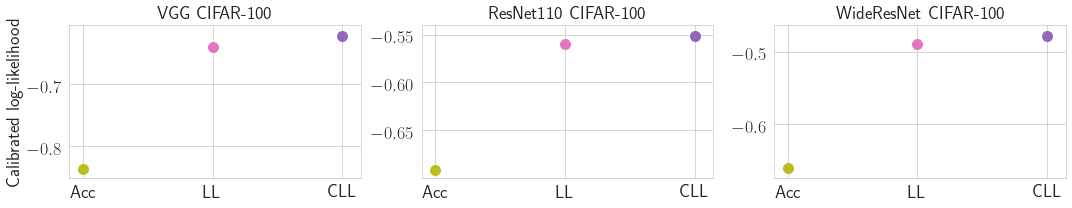

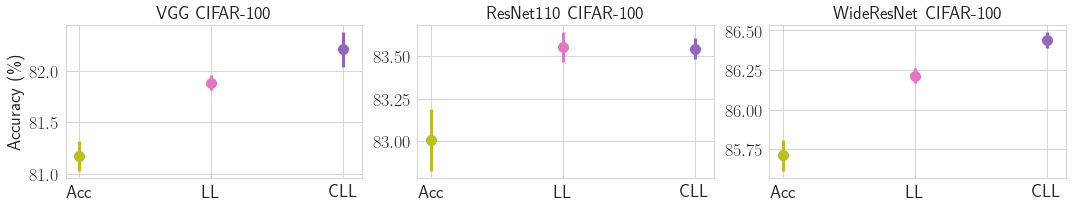

In [139]:
for metric in ['ll', 'acc']:
    params = {'legend.fontsize': 18,
             'axes.labelsize': 18,
    #          'figure.figsize': (6, 4),
             'axes.titlesize':18,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'lines.markersize': 10,
             'legend.markerscale': 1.,
             'legend.labelspacing': 1.,
             'figure.subplot.hspace': 0.3,
             'figure.subplot.wspace': 0.05,
             }
    pylab.rcParams.update(params)
    # models = ['VGG16BN', 'PreResNet110']
    models = [ 'VGG16BN', 'PreResNet110', 'WideResNet28x10']
#     augs = [ 'Clean', 'CF', 'MTrain', 'MGrid', 'GPS']
    augs = ['acc', 'll', 'cll']
    sample_nums = [100]
    datasets = ['CIFAR100']

    f = plt.figure(figsize=(15, 3))
    i = 1
    short_legend_augs_ordered = []
    for aug in augs:
        short_legend_augs_ordered.append(short_legend_augs[aug])

    for dataset in datasets:
        for model in models:
            plt.subplot(len(datasets), len(models), i)
            i += 1
            lines = []
            for j, aug in enumerate(augs):
                plot_augs = []
                legends = []
                for sample_num in sample_nums:
    #                 plot_augs.append(metric[dataset][model][aug][sample_num])
                    marker = 'o'
                    if sample_num < 100:
                        marker = 'x'
                    if aug != 'Clean' or sample_num == 100:
                        if aug == 'Clean':
                            sample_num = 1
                        val = df.query('dataset=="%s" and model=="%s" and method=="%s" and metric=="%s" and n_samples==%d and experiment=="SETUP2"' % (dataset, model, aug + ' (ts)', metric, sample_num))['mean'].item()
                        std = df.query('dataset=="%s" and model=="%s" and method=="%s" and metric=="%s" and n_samples==%d and experiment=="SETUP2"' % (dataset, model, aug + ' (ts)', metric, sample_num))['std'].item()
                        
                        # GOVNOKOD, SORYAN
                        pos_x = j + 0.2 * ((sample_num < 100) - 0.5) * (len(sample_nums) == 2)
                        
                        plt.errorbar([pos_x], [val], [std], c=colors_palette[colors_augs[aug]], elinewidth=3)
                        legends.append(plt.scatter([pos_x], [val], marker=marker,
                                    c=colors_palette[colors_augs[aug]]))
        
                plt.title(model_names[model] + ' ' + dataset_names[dataset])
                plt.xticks(np.arange(len(augs)), short_legend_augs_ordered)
                if i % (len(models)) == 2:
                    plt.ylabel(metric_names[metric])
    # lines[0]['facecolor'] = colors_palette[-1]
    # for i in range(2):
    #     legends[i].set_color(colors_palette[-1])
    # f.legend(legends, labels=['20 samples', '100 samples'], ncol=2, loc='upper center',
    #         bbox_to_anchor=(0.5, 1.08))
    handles = []
    if len(sample_nums) == 2:
        cross = plt.plot(np.nan, np.nan, color=colors_palette[-1], marker='x', linestyle='None',
                                  label='%d samples' % sample_nums[0])[0]
        handles.append(cross)
        circle = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker='o', linestyle='None',
                                  label='100 samples')
        handles.append(circle)
        f.legend(handles=handles, loc='upper center', ncol=2,
                bbox_to_anchor=(0.5, 1.08))
    plt.tight_layout()

# SETUP 3 - TRAINING ON CLEAN DATA

In [140]:
df.query('experiment=="SETUP3" and n_samples=="1" and metric == "ll"')

,dataset,model,method,n_samples,metric,experiment,mean,std,max
7,CIFAR10,PreResNet110,CF,1,ll,SETUP3,-0.178629,3.949011e-03,-0.174262
1007,CIFAR10,PreResNet110,CF (ts),1,ll,SETUP3,-0.155268,2.867484e-03,-0.151748
9007,CIFAR10,PreResNet110,Clean,1,ll,SETUP3,-0.179662,2.706930e-09,-0.179662
9017,CIFAR10,PreResNet110,Clean (ts),1,ll,SETUP3,-0.146181,8.892306e-05,-0.146113
9027,CIFAR10,PreResNet110,GPS,1,ll,SETUP3,-0.177818,1.574848e-03,-0.175943
10027,CIFAR10,PreResNet110,GPS (ts),1,ll,SETUP3,-0.154841,1.023024e-03,-0.153562
13027,CIFAR10,VGG16BN,CF,1,ll,SETUP3,-0.331191,5.552415e-03,-0.324949
14027,CIFAR10,VGG16BN,CF (ts),1,ll,SETUP3,-0.234363,3.146421e-03,-0.230456
22027,CIFAR10,VGG16BN,Clean,1,ll,SETUP3,-0.303975,3.885747e-09,-0.303975
22037,CIFAR10,VGG16BN,Clean (ts),1,ll,SETUP3,-0.218181,6.731319e-05,-0.218106


In [154]:
colors = {'VGG16BN': 'r',
          'PreResNet110': 'g',
          'WideResNet28x10': 'b'
         }
linestyles = {'CF': 'dashed',
              'MGrid': 'dotted',
              'MTrain': 'dotted',
              'GPS': 'solid',
              'Clean': (0, (1, 10))
             }
markers = {'CF': '+',
           'MGrid': (5, 0),
           'MTrain': (5, 0),
           'GPS': (5, 1),
           'Clean' : '>'
          }
legend_augs = {'CF': 'Standard crops and flips',
              'MGrid': 'Randaugment with M*',
              'MTrain': 'Augmentation as in training',
              'GPS': 'Optimal GPS policy',
              'Clean': 'Central crop'}
short_legend_augs = {'CF': 'CF',
                     'MGrid': 'M*',
                     'GPS': 'GPS',
                     'MTrain': 'Tr',
                     'Clean': 'CC'}
model_names = {'VGG16BN': 'VGG',
              'PreResNet110': 'ResNet110',
              'WideResNet28x10': 'WideResNet'}
metric_names = {'ll': r'Calibrated''\n'r'log-likelihood',
                'acc': 'Accuracy (\%)'}
colors_augs = {'CF': 0,
             'MGrid': 1,
             'GPS': 2,
             'Clean': 3,
             'MTrain': 4}
colors_palette = [
    '#bcbd22', '#e377c2', '#9467bd',
    '#8c564b', '#1f77b4', '#d62728',
    '#2ca02c', '#ff7f0e', '#7f7f7f']
dataset_names = {'CIFAR10': 'CIFAR-10',
                'CIFAR100': 'CIFAR-100'}

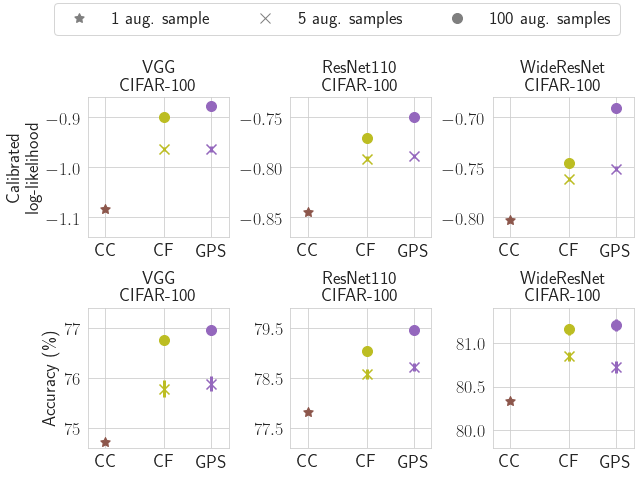

In [155]:
# datasets = ['CIFAR10', 'CIFAR100']
datasets = ['CIFAR100']
ticks = [[-1.1, -1.0, -0.9], [-0.85, -0.8, -0.75], [-0.7, -0.75, -0.8],
         [75, 76, 77], [77.5, 78.5, 79.5], [80, 80.5, 81.]]
for dataset in datasets:
    params = {'legend.fontsize': 18,
             'axes.labelsize': 18,
    #          'figure.figsize': (6, 4),
             'axes.titlesize':18,
             'xtick.labelsize':18,
             'ytick.labelsize':18,
             'lines.markersize': 10,
             'legend.markerscale': 1.,
             'legend.labelspacing': 1.,
             'figure.subplot.hspace': 0.3,
             'figure.subplot.wspace': 0.05,
             }
    pylab.rcParams.update(params)
    # models = ['VGG16BN', 'PreResNet110']
    models = [ 'VGG16BN', 'PreResNet110', 'WideResNet28x10']
    augs = [ 'Clean', 'CF', 'GPS']
    sample_nums = [5, 100]

    figsize = (9, 6)
    if dataset == 'CIFAR10':
        figsize = (10, 7)
    f = plt.figure(figsize=figsize)
    i = 1
    short_legend_augs_ordered = []
    for aug in augs:
        short_legend_augs_ordered.append(short_legend_augs[aug])

    metrics = ['ll', 'acc']
    for metric in metrics:
        for model in models:
            ax = plt.subplot(len(metrics), len(models), i)
            poses_x = []
            i += 1
            lines = []
            for j, aug in enumerate(augs):
                plot_augs = []
                legends = []
                for sample_num in sample_nums:
    #                 plot_augs.append(metric[dataset][model][aug][sample_num])
                    marker = 'o'
                    if sample_num < 100:
                        marker = 'x'
                    if aug != 'Clean' or sample_num == 100:
                        if aug == 'Clean':
                            sample_num = 1
                            marker = (5, 1)
                        val = df.query('dataset=="%s" and model=="%s" and method=="%s" and metric=="%s" and n_samples==%d and experiment=="SETUP3"' % (dataset, model, aug + ' (ts)', metric, sample_num))['mean'].item()
                        std = df.query('dataset=="%s" and model=="%s" and method=="%s" and metric=="%s" and n_samples==%d and experiment=="SETUP3"' % (dataset, model, aug + ' (ts)', metric, sample_num))['std'].item()
                        
                        # GOVNOKOD, SORYAN
                        pos_x = j + 0.2 * ((sample_num < 100) - 0.5) * (len(sample_nums) == 2)
                        if dataset == 'CIFAR100':
                            pos_x = j
                        if aug == 'GPS':
                            pos_x -= 0.2
                        
                        plt.errorbar([pos_x], [val], [std], c=colors_palette[colors_augs[aug]], elinewidth=3)
                        legends.append(plt.scatter([pos_x], [val], marker=marker,
                                    c=colors_palette[colors_augs[aug]]))
        
                plt.title(model_names[model] + '\n' + dataset_names[dataset])
                plt.xticks((0,1,1.8), short_legend_augs_ordered)
                plt.yticks(ticks[i-2])
                delta = max(ticks[i-2]) - min(ticks[i-2])
                ax.set_ylim(min(ticks[i-2]) - delta*0.2, max(ticks[i-2]) + delta*0.2)
                ax.set_xlim(-0.3, 2.1)
                if i-2 == 5:
                    ax.set_ylim(min(ticks[i-2]) - delta*0.2, max(ticks[i-2]) + delta*0.4)
                if i % (len(models)) == 2:
                    plt.ylabel(metric_names[metric])
    # lines[0]['facecolor'] = colors_palette[-1]
    # for i in range(2):
    #     legends[i].set_color(colors_palette[-1])
    # f.legend(legends, labels=['20 samples', '100 samples'], ncol=2, loc='upper center',
    #         bbox_to_anchor=(0.5, 1.08))
    handles = []
    if len(sample_nums) == 2:
        star = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker=(5, 1), linestyle='None',
                          label='1 aug. sample')
        handles.append(star)
        cross = plt.plot(np.nan, np.nan, color=colors_palette[-1], marker='x', linestyle='None',
                                  label='%d aug. samples' % sample_nums[0])[0]
        handles.append(cross)
        circle = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker='o', linestyle='None',
                                  label='100 aug. samples')
        handles.append(circle)
        f.legend(handles=handles, loc='upper center', ncol=3,
                bbox_to_anchor=(0.52, 1.12))
    else:
        star = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker=(5, 1), linestyle='None',
                          label='1 aug. sample')
        handles.append(star)
        circle = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker='o', linestyle='None',
                                  label='100 aug. samples')
        handles.append(circle)
        f.legend(handles=handles, loc='upper center', ncol=2,
                bbox_to_anchor=(0.7, 1.15))
    plt.tight_layout()
    plt.savefig('clean-%s.pdf' % dataset, bbox_inches="tight")

In [143]:
matplotlib.rcParams['font.family']

['sans-serif']

# SETUP 4 - TRANSFER

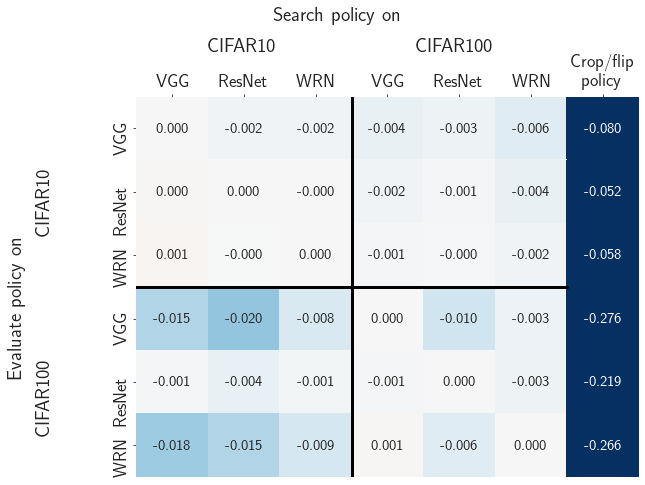

In [144]:
methods = [
           'CIFAR10-VGG16BN-stratvalid-policy.npz (ts)',
           'CIFAR10-PreResNet110-stratvalid-policy.npz (ts)',
           'CIFAR10-WideResNet28x10-stratvalid-policy.npz (ts)',
           'CIFAR100-VGG16BN-stratvalid-policy.npz (ts)',
           'CIFAR100-PreResNet110-stratvalid-policy.npz (ts)',
           'CIFAR100-WideResNet28x10-stratvalid-policy.npz (ts)',
           'cf'
          ]
params = []
for data in ['CIFAR10', 'CIFAR100']:
    for arch in ['VGG16BN', 'PreResNet110', 'WideResNet28x10']:
        params.append((data, arch))
ll = np.zeros((len(params), len(methods)))

for i, (data, arch) in enumerate(params):
    for j, method in enumerate(methods):
        if j == 6:
            ll[i, j] = df.query('dataset=="%s" and model=="%s" and method=="CF (ts)" and n_samples==100 and metric=="ll" and experiment=="SETUP3"' % (data, arch))['mean'].item()
        else:
            ll[i, j] = df.query('experiment=="SETUP4" and n_samples=="100" and metric == "ll" and dataset=="%s" and model=="%s" and method=="%s"' % (data, arch, method))['mean'].item()
dll = (ll - ll.diagonal().reshape(-1, 1))
fig, ax = plt.subplots(figsize=(9, 7))
ax.xaxis.tick_top()
ax.yaxis.tick_left()
sns.heatmap(dll, center=0, cmap="RdBu_r",
            annot=True, fmt=".3f", annot_kws={'fontsize':15},
            yticklabels=["   VGG", "   ResNet", "   WRN", "   VGG", "   ResNet", "   WRN"],
            xticklabels=["VGG", "ResNet", "WRN", "VGG", "ResNet", "WRN", r"Crop/flip""\n"r"policy"],
            ax=ax, cbar=False, vmin=-0.05)
# ax.text(0.35, 6.7, r'$\Delta cLL$', fontsize=20)

ax.text(1.0, -0.7, 'CIFAR10', fontsize=20)
ax.text(3.9, -0.7, 'CIFAR100', fontsize=20)
# ax.text(6.15, -0.3, 'Crop/\n flip', fontsize=20)
ax.text(1.9, -1.2, 'Search policy on', fontsize=20)
ax.text(-1.4, 2.15, 'CIFAR10', fontsize=20, rotation='vertical')
ax.text(-1.4, 5.3, 'CIFAR100', fontsize=20, rotation='vertical')
ax.text(-1.8, 4.4, 'Evaluate policy on', fontsize=20, rotation='vertical')

plt.plot([3.0, 3.0], [-2.0,  6.0], color='k', lw=3)
plt.plot([-2.0, 6.0], [3.0,  3.0], color='k', lw=3)
plt.savefig('transfer-cifar.pdf', bbox_inches="tight")

# SETUP 5 - ENSEMBLES

In [145]:
df.query('experiment=="SETUP5" and metric=="ll" and n_samples=="100"')

,dataset,model,method,n_samples,metric,experiment,mean,std,max
74596,CIFAR100,WideResNet28x10,CF,100,ll,SETUP5,-0.588617,0.000115,-0.588453
76096,CIFAR100,WideResNet28x10,CF (ts),100,ll,SETUP5,-0.448881,0.000278,-0.448636
86628,CIFAR100,WideResNet28x10,GPS1,100,ll,SETUP5,-0.623767,0.000478,-0.623239
87128,CIFAR100,WideResNet28x10,GPS1 (ts),100,ll,SETUP5,-0.421488,0.000787,-0.420365
87628,CIFAR100,WideResNet28x10,GPS5,100,ll,SETUP5,-0.590886,0.000526,-0.590147
88128,CIFAR100,WideResNet28x10,GPS5 (ts),100,ll,SETUP5,-0.415225,0.000678,-0.414424
89127,CIFAR100,WideResNet28x10,MGrid,100,ll,SETUP5,-0.600867,0.004429,-0.594160
90127,CIFAR100,WideResNet28x10,MGrid (ts),100,ll,SETUP5,-0.430114,0.002228,-0.427824
91127,CIFAR100,WideResNet28x10,MTrain,100,ll,SETUP5,-0.728160,0.016183,-0.707642
92127,CIFAR100,WideResNet28x10,MTrain (ts),100,ll,SETUP5,-0.436919,0.000257,-0.436706


In [146]:
colors = {'VGG16BN': 'r',
          'PreResNet110': 'g',
          'WideResNet28x10': 'b'
         }
linestyles = {'CF': 'dashed',
              'MGrid': 'dotted',
              'MTrain': 'dotted',
              'GPS1': 'solid',
              'GPS5': 'solid',
              'Clean': (0, (1, 10))
             }
markers = {'CF': '+',
           'MGrid': (5, 0),
           'MTrain': (5, 0),
           'GPS1': (5, 1),
           'GPS5': (5, 1),
           'Clean' : '>'
          }
legend_augs = {'CF': 'Standard crops and flips',
              'MGrid': 'Randaugment with M*',
              'MTrain': 'Augmentation as in training',
              'GPS1': 'Optimal GPS policy for a single network',
              'GPS5': 'Optimal GPS policy for an ensemble',
              'Clean': 'Central crop'}
short_legend_augs = {'CF': 'CF',
                     'MGrid': r"M*""\n"r"1",
                     'GPS1': r"GPS""\n"r"1",
                     'GPS5': r"GPS""\n"r"ens",
                     'MTrain': 'Tr',
                     'Clean': 'CC'}
model_names = {'VGG16BN': 'VGG',
              'PreResNet110': 'ResNet110',
              'WideResNet28x10': 'WideResNet'}
metric_names = {'ll': r'Calibrated''\n'r'log-likelihood',
                'acc': r'Accuracy (\%)'}
colors_augs = {'CF': 0,
             'MGrid': 1,
             'GPS1': 5,
             'GPS5': 2,
             'Clean': 3,
             'MTrain': 4}
colors_palette = [
    '#bcbd22', '#e377c2', '#9467bd',
    '#8c564b', '#1f77b4', '#d62728',
    '#2ca02c', '#ff7f0e', '#7f7f7f']
dataset_names = {'CIFAR10': 'CIFAR-10',
                'CIFAR100': 'CIFAR-100'}

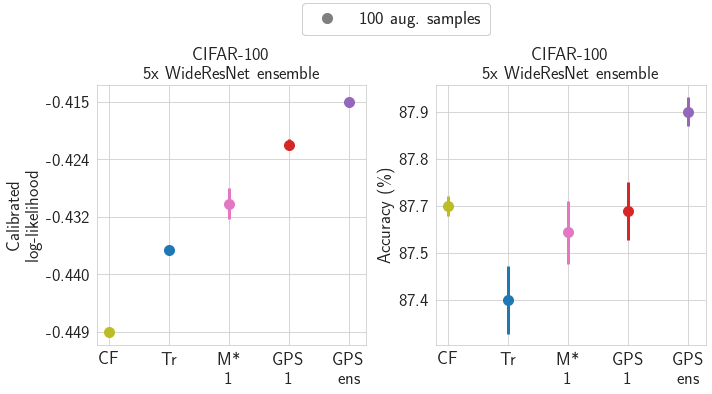

In [147]:
params = {'legend.fontsize': 18,
         'axes.labelsize': 18,
#          'figure.figsize': (6, 4),
         'axes.titlesize':18,
         'xtick.labelsize':18,
         'ytick.labelsize':18,
         'lines.markersize': 10,
         'legend.markerscale': 1.,
         'legend.labelspacing': 1.,
         'figure.subplot.hspace': 0.3,
         'figure.subplot.wspace': 0.05,
         }
pylab.rcParams.update(params)

f = plt.figure(figsize=(10, 5))

for ii, metric in enumerate(['ll', 'acc']):
    # models = ['VGG16BN', 'PreResNet110']
    models = [ 'WideResNet28x10']
#     augs = [ 'Clean', 'CF', 'MTrain', 'MGrid', 'GPS']
#     augs = ['Clean', 'CF', 'MTrain', 'MGrid', 'GPS1', 'GPS5']
    augs = ['CF', 'MTrain', 'MGrid', 'GPS1', 'GPS5']
    sample_nums = [100]
    datasets = ['CIFAR100']
    
    min_ = +150000
    max_ = -100500
    plt.subplot(1, 2, ii + 1)
    
    i = 1
    short_legend_augs_ordered = []
    for aug in augs:
        short_legend_augs_ordered.append(short_legend_augs[aug])

    for dataset in datasets:
        for model in models:
#             plt.subplot(len(datasets), len(models), i)
            i += 1
            lines = []
            for j, aug in enumerate(augs):
                plot_augs = []
                legends = []
                for sample_num in sample_nums:
    #                 plot_augs.append(metric[dataset][model][aug][sample_num])
                    if sample_num == 5 and aug in ['MTrain']:
                        continue
                    marker = 'o'
                    if sample_num < 100:
                        marker = 'x'
                    if aug != 'Clean' or sample_num == 100:
                        if aug == 'Clean':
                            sample_num = 1
                            marker = (5, 1)
                        val = df.query('dataset=="%s" and model=="%s" and method=="%s" and metric=="%s" and n_samples==%d and experiment=="SETUP5"' % (dataset, model, aug + ' (ts)', metric, sample_num))['mean'].item()
                        std = df.query('dataset=="%s" and model=="%s" and method=="%s" and metric=="%s" and n_samples==%d and experiment=="SETUP5"' % (dataset, model, aug + ' (ts)', metric, sample_num))['std'].item()
                        min_ = min(min_, val)
                        max_ = max(max_, val)
                        # GOVNOKOD, SORYAN
                        pos_x = j + 0.2 * ((sample_num < 100) - 0.5) * (len(sample_nums) == 2)
                        
                        plt.errorbar([pos_x], [val], yerr=[std], c=colors_palette[colors_augs[aug]], elinewidth=3)
                        legends.append(plt.scatter([pos_x], [val], marker=marker,
                                    c=colors_palette[colors_augs[aug]]))
        
                plt.title(dataset_names[dataset] + '\n' + '5x ' + model_names[model] + ' ensemble' )
                plt.xticks(np.arange(len(augs)), short_legend_augs_ordered)
#                 if i % (len(models)) == 2:
                plt.ylabel(metric_names[metric])
                plt.yticks(np.linspace(min_, max_, 5))
                if metric == 'll':
                    from matplotlib.ticker import FormatStrFormatter
                    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
                else:
                    plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
#                 if i % (len(models)) == 2:
#                 plt.yticks(np.arange(len(augs)), short_legend_augs_ordered)
#                 else:
#                     plt.yticks(np.arange(len(augs)), ['']*len(augs))
#                 plt.xlabel(metric_names[metric])
    # lines[0]['facecolor'] = colors_palette[-1]
    # for i in range(2):
    #     legends[i].set_color(colors_palette[-1])
    # f.legend(legends, labels=['20 samples', '100 samples'], ncol=2, loc='upper center',
    #         bbox_to_anchor=(0.5, 1.08))
    handles = []
    if len(sample_nums) == 2:
        star = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker=(5, 1), linestyle='None',
                          label='1 aug. sample')
        handles.append(star)
        cross = plt.plot(np.nan, np.nan, color=colors_palette[-1], marker='x', linestyle='None',
                                  label='%d aug. samples' % sample_nums[0])[0]
        handles.append(cross)
        circle = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker='o', linestyle='None',
                                  label='100 aug. samples')
        handles.append(circle)
        f.legend(handles=handles, loc='upper center', ncol=3,
                bbox_to_anchor=(0.55, 1.15))
    else:
#         star = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker=(5, 1), linestyle='None',
#                           label='1 aug. sample')
#         handles.append(star)
        circle = matplotlib.lines.Line2D([], [], color=colors_palette[-1], marker='o', linestyle='None',
                                  label='100 aug. samples')
        handles.append(circle)
        f.legend(handles=handles, loc='upper center', ncol=2,
                bbox_to_anchor=(0.55, 1.11))
plt.tight_layout()
plt.savefig('ensembles.pdf', bbox_inches="tight")

# Setup 6 - TEMPERATURE

In [148]:
df.query('n_samples==100 and experiment=="SETUP1" and metric=="temperature" and method=="GPS (ts)"')

,dataset,model,method,n_samples,metric,experiment,mean,std,max
11018,CIFAR10,PreResNet110,GPS (ts),100,temperature,SETUP1,0.571281,0.001093,0.572734
24038,CIFAR10,VGG16BN,GPS (ts),100,temperature,SETUP1,0.629922,0.002107,0.631875
37058,CIFAR10,WideResNet28x10,GPS (ts),100,temperature,SETUP1,0.599891,0.002561,0.602187
51077,CIFAR100,PreResNet110,GPS (ts),100,temperature,SETUP1,0.661562,0.000521,0.662109
68097,CIFAR100,VGG16BN,GPS (ts),100,temperature,SETUP1,0.661344,0.000910,0.662344
86127,CIFAR100,WideResNet28x10,GPS (ts),100,temperature,SETUP1,0.600156,0.000743,0.600937


In [149]:
df.query('n_samples==100 and experiment=="SETUP6" and metric=="temperature" and method=="GPS (ts)"')

,dataset,model,method,n_samples,metric,experiment,mean,std,max
51079,CIFAR100,PreResNet110,GPS (ts),100,temperature,SETUP6,0.665312,0.001961,0.667187
68099,CIFAR100,VGG16BN,GPS (ts),100,temperature,SETUP6,0.662656,0.001398,0.664062
86129,CIFAR100,WideResNet28x10,GPS (ts),100,temperature,SETUP6,0.613281,0.001914,0.615625


/Users/senya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/senya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
/Users/senya/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the 

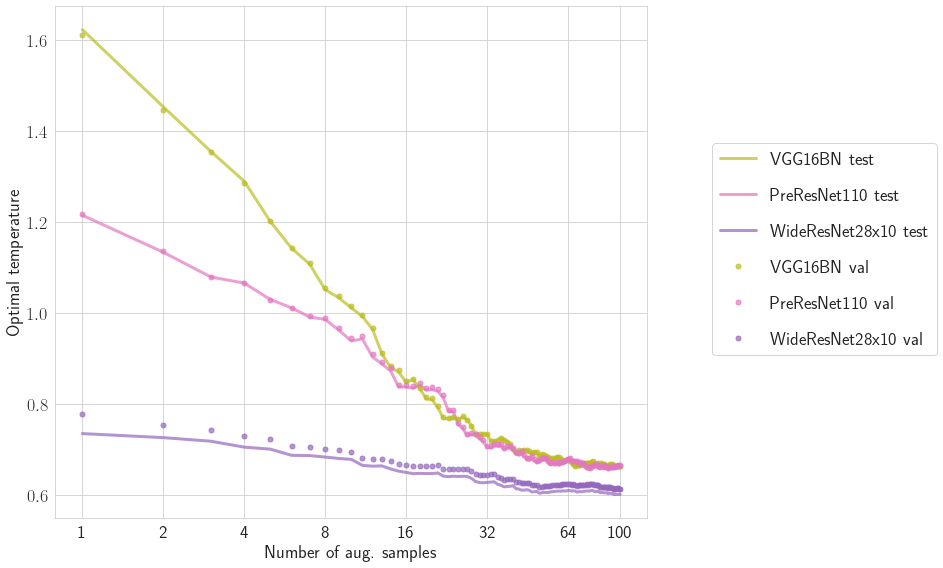

In [150]:
params = {'legend.fontsize': 18,
         'axes.labelsize': 18,
         'axes.titlesize':18,
         'xtick.labelsize':18,
         'ytick.labelsize':18,
         'lines.markersize': 10,
         'legend.markerscale': 1.,
         'legend.labelspacing': 1.,
         'figure.subplot.hspace': 0.3,
         'figure.subplot.wspace': 0.05,
         }
pylab.rcParams.update(params)
plt.figure(figsize=(14, 8))
linestest = []
linesval = []
for data in ['test', 'val']:
    for i, arch in enumerate(['VGG16BN', 'PreResNet110', 'WideResNet28x10']):
        t_test = []
        t_val = []
        for n in range(1, 101):
            t_test.append(df.query('model=="%s" and dataset=="CIFAR100" and n_samples==%d and experiment=="SETUP1" and metric=="temperature" and method=="GPS (ts)"' % (arch, n))['mean'].item())
            t_val.append(df.query('model=="%s" and dataset=="CIFAR100" and n_samples==%d and experiment=="SETUP6" and metric=="temperature" and method=="GPS (ts)"' % (arch, n))['mean'].item())
        if data == 'test':
            plt.plot(range(1, 101), t_test, '-', c=colors_palette[i], linewidth=3, alpha=0.7, label=arch + ' test')
        else:
            plt.plot(range(1, 101), t_val, '.', c=colors_palette[i], linewidth=3, alpha=0.7, label=arch + ' val')
plt.legend(loc='upper center', ncol=1, bbox_to_anchor=(1.3, 0.75))
plt.axes().set_xlabel('Number of aug. samples')
plt.axes().set_xscale('log', basex=2)
plt.axes().set_xticks([1, 2, 4, 8, 16, 32, 64, 100])
plt.axes().set_xticklabels([str(x) for x in [1, 2, 4, 8, 16, 32, 64, 100]])
# plt.axes().xaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
plt.axes().set_ylabel('Optimal temperature')
plt.tight_layout()
plt.savefig('temp.pdf', bbox_inches='tight')

# M GRIDSEARCH

In [151]:
from collections import defaultdict

Ms = list(range(0, 56, 5))
accs_ra = defaultdict(lambda: defaultdict(list))
clls_ra = defaultdict(lambda: defaultdict(list))
lls_ra = defaultdict(lambda: defaultdict(list))
accs_cl = defaultdict(lambda: defaultdict(list))
clls_cl = defaultdict(lambda: defaultdict(list))
lls_cl = defaultdict(lambda: defaultdict(list))
for dataset in ['CIFAR10', 'CIFAR100']:
    for arch in ['VGG16BN', 'PreResNet110', 'WideResNet28x10']:
        for M in Ms:
            d_ra = pd.read_csv(path+'/GRID/{data}-{arch}-randaugment-GRID-{data}-{arch}-randaugment-2000-M45-padded.pt-3-{M}.csv.cvs'.format(
                                data=dataset, arch=arch, M=M
                            ))
            d_cl = pd.read_csv(glob.glob(path+'/GRID/{data}-{arch}-*-3-{M}.csv.csv'.format(data=dataset, arch=arch, M=M))[0])
            accs_ra[dataset][arch].append(list(d_ra.query('method == "randaugment (ts)" and metric == "acc" and n_samples == 100').value)[0])
            clls_ra[dataset][arch].append(list(d_ra.query('method == "randaugment (ts)" and metric == "ll" and n_samples == 100').value)[0])
            lls_ra[dataset][arch].append(list(d_ra.query('method == "randaugment" and metric == "ll" and n_samples == 100').value)[0])
            accs_cl[dataset][arch].append(list(d_cl.query('method == "randaugment (ts)" and metric == "acc" and n_samples == 100').value)[0])
            clls_cl[dataset][arch].append(list(d_cl.query('method == "randaugment (ts)" and metric == "ll" and n_samples == 100').value)[0])
            lls_cl[dataset][arch].append(list(d_cl.query('method == "randaugment" and metric == "ll" and n_samples == 100').value)[0])
for dataset in ['CIFAR10', 'CIFAR100']:
    print(dataset)
    for arch in ['VGG16BN', 'PreResNet110', 'WideResNet28x10']:
        i = np.argmax(clls_ra[dataset][arch])
        i = 0
        print(arch + ' ' + 'acc: %.4f, cll: %.4f' % (accs_ra[dataset][arch][i], clls_ra[dataset][arch][i]))
        i = np.argmax(clls_cl[dataset][arch])
        i = 0
        print(arch + ' ' + 'acc: %.4f, cll: %.4f' % (accs_cl[dataset][arch][i], clls_cl[dataset][arch][i]))
current_palette = sns.color_palette()

CIFAR10
VGG16BN acc: 0.9731, cll: -0.0852
VGG16BN acc: 0.9470, cll: -0.1770
PreResNet110 acc: 0.9760, cll: -0.0761
PreResNet110 acc: 0.9577, cll: -0.1385
WideResNet28x10 acc: 0.9840, cll: -0.0525
WideResNet28x10 acc: 0.9641, cll: -0.1190
CIFAR100
VGG16BN acc: 0.8155, cll: -0.6699
VGG16BN acc: 0.7641, cll: -0.9472
PreResNet110 acc: 0.8351, cll: -0.5650
PreResNet110 acc: 0.7900, cll: -0.7973
WideResNet28x10 acc: 0.8587, cll: -0.5370
WideResNet28x10 acc: 0.8078, cll: -0.7280


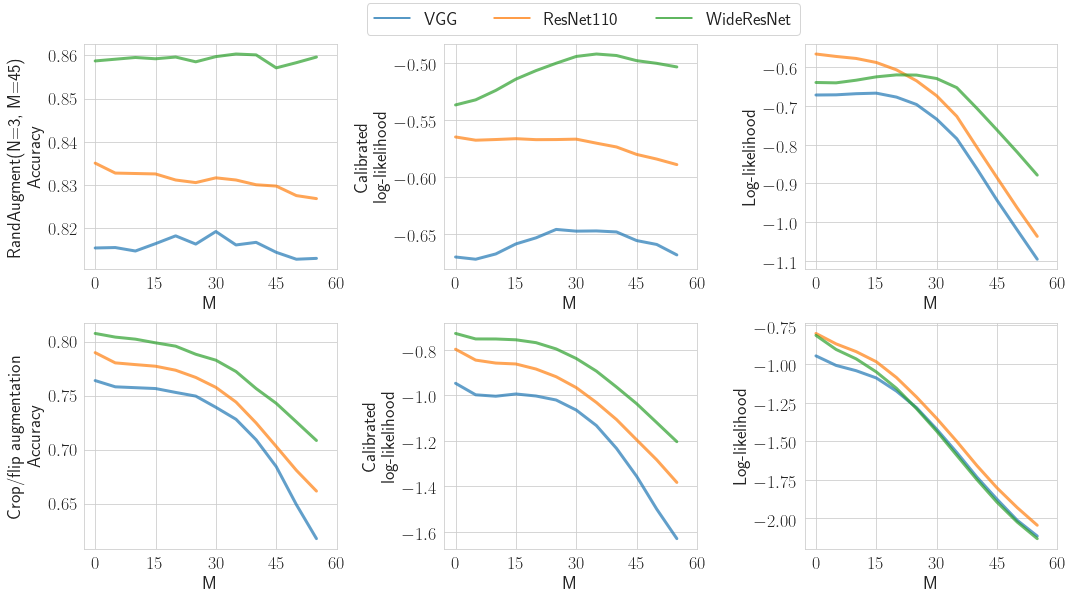

In [157]:
dataset = 'CIFAR100'
params = {'legend.fontsize': 18,
         'axes.labelsize': 18,
         'axes.titlesize':18,
         'xtick.labelsize':18,
         'ytick.labelsize':18,
         'lines.markersize': 10,
         'legend.markerscale': 1.,
         'legend.labelspacing': 1.,
         'figure.subplot.hspace': 0.3,
         'figure.subplot.wspace': 0.05,
         }
pylab.rcParams.update(params)
f = plt.figure(figsize=(15, 8))
j = 0
js = [1, 2, 3, 4, 5, 6]
axs = []
for i, (accs, clls, lls) in enumerate([(accs_ra, clls_ra, lls_ra), (accs_cl, clls_cl, lls_cl)]):
    ax = plt.subplot(2, 3, js[j])
    axs.append(ax)
    j += 1
    plt.plot(Ms, accs[dataset]['VGG16BN'], label='VGG16BN', c=current_palette.as_hex()[0], linewidth=3, alpha=0.7)
    plt.plot(Ms, accs[dataset]['PreResNet110'], label='PreResNet110', c=current_palette.as_hex()[1], linewidth=3, alpha=0.7)
    plt.plot(Ms, accs[dataset]['WideResNet28x10'], label='WideResNet28x10', c=current_palette.as_hex()[2], linewidth=3, alpha=0.7)
    ax.set_xlabel('M')
    ax.set_ylabel((r'RandAugment(N=3, M=45)' if i == 0 else r'Crop/flip augmentation') + '\n'r'Accuracy')
#     ax.set_title('RandAugment(N=3, M=45)' if i == 0 else 'Crop/flip augmentation')
    ax.set_xticks([0, 15, 30, 45, 60])
#     plt.legend(loc=0, ncol=2, bbox_to_anchor=(1.0, -0.2))

    
    ax = plt.subplot(2, 3, js[j])
    axs.append(ax)
    j += 1
    plt.plot(Ms, clls[dataset]['VGG16BN'], label='VGG16BN', c=current_palette.as_hex()[0], linewidth=3, alpha=0.7)
    plt.plot(Ms, clls[dataset]['PreResNet110'], label='PreResNet110', c=current_palette.as_hex()[1], linewidth=3, alpha=0.7)
    plt.plot(Ms, clls[dataset]['WideResNet28x10'], label='WideResNet28x10', c=current_palette.as_hex()[2], linewidth=3, alpha=0.7)
    ax.set_xlabel('M')
    ax.set_ylabel(r'Calibrated''\n'r'log-likelihood')
    ax.set_xticks([0, 15, 30, 45, 60])
#     plt.legend(loc=0, ncol=2, bbox_to_anchor=(1.0, -0.2))

    
    ax = plt.subplot(2, 3, js[j])
    axs.append(ax)
    j += 1
    plt.plot(Ms, lls[dataset]['VGG16BN'], label='VGG16BN', c=current_palette.as_hex()[0], linewidth=3, alpha=0.7)
    plt.plot(Ms, lls[dataset]['PreResNet110'], label='PreResNet110', c=current_palette.as_hex()[1], linewidth=3, alpha=0.7)
    plt.plot(Ms, lls[dataset]['WideResNet28x10'], label='WideResNet28x10', c=current_palette.as_hex()[2], linewidth=3, alpha=0.7)
    ax.set_xlabel('M')
    ax.set_ylabel('Log-likelihood')
    ax.set_xticks([0, 15, 30, 45, 60])
#     plt.legend(loc=0, ncol=2, bbox_to_anchor=(1.0, -0.2))

vgg = matplotlib.lines.Line2D([], [], color=current_palette.as_hex()[0], linestyle='-',
                  label='VGG')
rn110 = matplotlib.lines.Line2D([], [], color=current_palette.as_hex()[1], linestyle='-',
                          label='ResNet110')
wrn = matplotlib.lines.Line2D([], [], color=current_palette.as_hex()[2], linestyle='-',
                          label='WideResNet')
f.legend(handles=[vgg, rn110, wrn], loc='upper center', ncol=3,
        bbox_to_anchor=(0.54, 1.05))

plt.tight_layout()
plt.savefig('mgrid.pdf', bbox_inches='tight')